In [48]:
#imports and constants
import math 
from urllib.request import urlretrieve as rx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
EarthRadius = 6378137
MinLatitude = -85.05112878
MaxLatitude = 85.05112878
MinLongitude = -180
MaxLongitude = 180

In [9]:
def Clip(n, minValue, maxValue):
    """
    Clips a number to the specified minimum and maximum values
    input number and its min&max range
    output clipped value in range min and max"""
    return min(max(n,minValue),maxValue)

def MapSize(levelofDetail):
    """
    Determines the map width and height (in pixels) at a specified level
    of detail //map width = map height = 256 * 2pow(level) pixels
    input level of detail 1 to 23
    output returns height=width of map"""
    return int(256 << levelofDetail)

def GroundResolution(latitude,levelofDetail):
    """ 
    Determines the ground resolution (in meters per pixel) at a specified
    latitude and level of detail.
    input latitude,level of detail
    output ground resolution in meters per pixel"""
    latitude=Clip(latitude,MinLatitude,MaxLatitude)
    return math.cos(latitude * math.pi / 180) * 2 * math.pi * EarthRadius / MapSize(levelofDetail)

def MapScale(latitude,levelofDetail,screenDpi):
    """
    Determines the map scale at a specified latitude, level of detail,
    and screen resolution.
    input latitude,levelofDetail,screenDpi
    output mapscale"""
    return GroundResolution(latitude,levelofDetail)*screenDpi/0.0254

def LatLongToPixelXY(latitude,longitude,levelofDetail):
    """
    Converts a point from latitude/longitude WGS-84 coordinates (in degrees)
    into pixel XY coordinates at a specified level of detail.
    input latitude,level of detail,screen dpi
    output pixelX, pixelY"""
    latitude = Clip(latitude, MinLatitude, MaxLatitude)
    longitude = Clip(longitude, MinLongitude, MaxLongitude)
    
    x=(longitude+180)/360
    sinLatitude=math.sin(latitude*math.pi/180)
    y=0.5-math.log((1 + sinLatitude) / (1 - sinLatitude))/(4*math.pi)
    
    mapSize=MapSize(levelofDetail)
    pixelX=Clip(x*mapSize+0.5,0,mapSize-1)
    pixelY=Clip(y*mapSize+0.5,0,mapSize-1)
    return int(pixelX),int(pixelY)
"""
def PixelXYtoLatLong(pixelX,pixelY,levelofDetail):
    Converts a pixel from pixel XY coordinates at a specified level of detail
    into latitude/longitude WGS-84 coordinates (in degrees).
    input: pixelX,pixelY,level of detail
    output: latitude,longitude
    mapSize=MapSize(levelofDetail)
    x=(Clip(pixelX,0,mapSize-1)/mapSize)-0.5
    y=0.5- (Clip(pixelY,0,mapSize-1)/mapSize)
    
    latitude=90- 360*math.atan(math.exp(-y*2*math.pi))/math.pi
    longitude=360*x
    return latitude,longitude
"""    

def pixelXYToTileXY(pixelX,pixelY):
    """
     Converts pixel XY coordinates into tile XY coordinates of the tile containing
    the specified pixel.
    input :pixelX,pixelY
    output:tileX,tileY
    """
    tileX=pixelX/256
    tileY=pixelY/256
    return int(tileX),int(tileY)

"""   
def TileToPixelXY(tileX,tileY):
    Converts tile XY coordinates into pixel XY coordinates of the upper-left pixel
    of the specified tile.
    input: tileX,tileY
    output: pixelX,pixelY
    pixelX=tileX*256
    pixelY=tileY*256
    return int(pixelX),int(pixelY)
"""

def TileXYToQuadKey(tileX,tileY,levelofDetail):
    """
    Converts tile XY coordinates into a QuadKey at a specified level of detail.
    input:tileX,tileYlevel of detail
    output: quadkey string"""
    quadKey=[]
    for i in range(levelofDetail,0,-1):
        digit=0
        mask=1 <<(i-1)
        if (tileX & mask)!=0:
            digit+=1
        if (tileY & mask)!=0:
            digit+=1
            digit+=1
        quadKey.append(str(digit))
    return "".join(quadKey)

def QuadkeyToTileXY(quadKey):
    """
     Converts a QuadKey into tile XY coordinates.
     input: quadkey
     output: tileX,tileY,levelofDetail"""
    tileX=0
    tileY=0
    levelofDetail=len(quadKey)
    for i in range(levelofDetail,0,-1):
        mask=1 <<(i-1)
        q=quadKey[levelofDetail-i]
        if q=='0':
            break
        elif q=='1':
            tileX |=mask
            break
        elif q=='2':
            tileY |=mask
            break
        elif q=='3':
            tileX |=mask
            tileY |=mask
            break
        else:
            print("invalid quadKey")
            

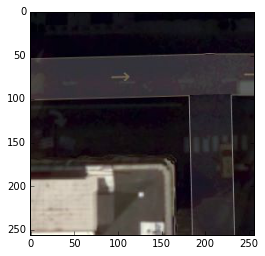

In [61]:
def get_image(lat,long,levelofDetail,name):
    """ 
    gets the image for given parameters
    input:latitude, longitude,levelofDetail, name to save img
    output: returns img as np array
    """
    pixelX,pixelY=LatLongToPixelXY(lat,long,levelofDetail)
    tileX,tileY=pixelXYToTileXY(pixelX,pixelY)
    q=TileXYToQuadKey(tileX,tileY,levelofDetail)
    part1_url=" http://h0.ortho.tiles.virtualearth.net/tiles/h"
    part2_url=".jpeg?g=131"
    request_url=part1_url+q+part2_url
    rx(part1_url+q+part2_url,name+".jpeg")
    return plt.imread(name+".jpeg")

def find_image(lat,long):
    """finds the higest resolution/levelofDetail image available
    input:latitude,longitude
    output returns img as np array"""
    for i in range(23,1,-1):
        img=get_image(lat,long,i,str(lat)+str(long))
        if np.array_equal(img,plt.imread("empty.jpeg")):
            {}#find the next lower levelofDetail img
        else:
            break
    return plt.imread(str(lat)+str(long)+".jpeg")
lat=41.8781
long=-87.6298
plt.imshow(find_image(lat,long))
